# Recurrent Neural Network (RNN) for Text Classification

## 1. Setup and Data Loading

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pickle
import json
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [2]:
# Load NusaX-Sentiment dataset
def load_nusax_sentiment_data():
    """
    Load NusaX-Sentiment dataset from local CSV files
    """
    try:
        # Define paths to your dataset files
        data_dir = "../data/nusax_sentiment"
        train_file = os.path.join(data_dir, "train.csv")
        valid_file = os.path.join(data_dir, "valid.csv")
        test_file = os.path.join(data_dir, "test.csv")
        
        # Load the datasets
        train_df = pd.read_csv(train_file)
        valid_df = pd.read_csv(valid_file)
        test_df = pd.read_csv(test_file)
        
        # Convert string labels to integer codes
        label_categories = pd.Categorical(train_df['label'].values)
        train_df['label'] = label_categories.codes
        label_mapping = dict(enumerate(label_categories.categories))
        
        # Use the same mapping for valid and test
        valid_df['label'] = pd.Categorical(valid_df['label'].values, categories=label_categories.categories).codes
        test_df['label'] = pd.Categorical(test_df['label'].values, categories=label_categories.categories).codes
        
        print("Dataset loaded successfully from local files.")
        print(f"Label mapping: {label_mapping}")
        
        return train_df, valid_df, test_df
        
    except FileNotFoundError as e:
        print(f"Error: Could not find dataset files. {e}")
        print("Creating synthetic dataset for demonstration...")
        return create_synthetic_sentiment_data()

def create_synthetic_sentiment_data():
    """
    Create synthetic sentiment data if real dataset is not available
    """
    # Synthetic Indonesian text samples
    positive_texts = [
        "Saya sangat senang dengan produk ini",
        "Film ini benar-benar luar biasa dan menghibur",
        "Pelayanan yang sangat memuaskan dan ramah",
        "Makanan di restoran ini enak sekali",
        "Pengalaman yang menyenangkan dan tak terlupakan"
    ] * 100
    
    negative_texts = [
        "Saya kecewa dengan kualitas produk ini",
        "Film ini membosankan dan tidak menarik",
        "Pelayanan yang buruk dan tidak profesional",
        "Makanan di sini tidak enak dan mahal",
        "Pengalaman yang mengecewakan dan merugikan"
    ] * 100
    
    neutral_texts = [
        "Produk ini biasa saja tidak istimewa",
        "Film ini cukup bagus untuk ditonton",
        "Pelayanan standar seperti tempat lain",
        "Makanan di sini rasanya biasa saja",
        "Pengalaman yang cukup normal dan wajar"
    ] * 100
    
    # Create dataset
    texts = positive_texts + negative_texts + neutral_texts
    labels = [2] * len(positive_texts) + [0] * len(negative_texts) + [1] * len(neutral_texts)
    
    # Create DataFrame
    df = pd.DataFrame({'text': texts, 'label': labels})
    
    # Split into train, val, test
    train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    
    return train_df, val_df, test_df

# Load the dataset
train_df, val_df, test_df = load_nusax_sentiment_data()

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")
print(f"\nLabel distribution in training set:")
print(train_df['label'].value_counts().sort_index())


Error: Could not find dataset files. [Errno 2] No such file or directory: '../data/nusax_sentiment\\train.csv'
Creating synthetic dataset for demonstration...
Train set size: 900
Validation set size: 300
Test set size: 300

Label distribution in training set:
label
0    300
1    300
2    300
Name: count, dtype: int64


## 2. Text Preprocessing and Tokenization

In [3]:
# Text preprocessing and tokenization
def preprocess_text(texts, max_features=10000, max_length=100):
    """
    Preprocess text data using TextVectorization
    
    Parameters:
    - texts: list of text strings
    - max_features: maximum vocabulary size
    - max_length: maximum sequence length
    
    Returns:
    - vectorizer: fitted TextVectorization layer
    - sequences: tokenized sequences
    """
    # Create TextVectorization layer
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_features,
        output_sequence_length=max_length,
        output_mode='int'
    )
    
    # Adapt vectorizer to training texts
    vectorizer.adapt(texts)
    
    # Transform texts to sequences
    sequences = vectorizer(texts)
    
    return vectorizer, sequences

# Preprocess the data
MAX_FEATURES = 10000
MAX_LENGTH = 100

# Fit vectorizer on training data and transform all sets
vectorizer, train_sequences = preprocess_text(train_df['text'].values, MAX_FEATURES, MAX_LENGTH)
_, val_sequences = preprocess_text(val_df['text'].values, MAX_FEATURES, MAX_LENGTH)
_, test_sequences = preprocess_text(test_df['text'].values, MAX_FEATURES, MAX_LENGTH)

# Use the same vectorizer for all sets
val_sequences = vectorizer(val_df['text'].values)
test_sequences = vectorizer(test_df['text'].values)

# Convert to numpy arrays
train_sequences = train_sequences.numpy()
val_sequences = val_sequences.numpy()
test_sequences = test_sequences.numpy()

train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

# Get vocabulary info
vocab_size = len(vectorizer.get_vocabulary())
num_classes = len(np.unique(train_labels))

print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {MAX_LENGTH}")
print(f"Training sequences shape: {train_sequences.shape}")
print(f"Training labels shape: {train_labels.shape}")

Vocabulary size: 51
Number of classes: 3
Sequence length: 100
Training sequences shape: (900, 100)
Training labels shape: (900,)


## 3. Model Building Functions

In [4]:
def build_rnn_model(rnn_layers=1, units_per_layer=[64], bidirectional=False, 
                    embedding_dim=128, dropout_rate=0.3, vocab_size=10000, 
                    num_classes=3, sequence_length=100):
    """
    Build RNN model with specified configuration
    
    Parameters:
    - rnn_layers: number of RNN layers
    - units_per_layer: list of units for each RNN layer
    - bidirectional: whether to use bidirectional RNN
    - embedding_dim: embedding dimension
    - dropout_rate: dropout rate
    - vocab_size: vocabulary size
    - num_classes: number of output classes
    - sequence_length: input sequence length
    
    Returns:
    - model: compiled Keras model
    """
    model = tf.keras.Sequential()
    
    # Embedding layer
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length,
        name='embedding'
    ))
    
    # RNN layers
    for i in range(rnn_layers):
        # Return sequences for all layers except the last one
        return_sequences = i < rnn_layers - 1
        
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                tf.keras.layers.SimpleRNN(
                    units_per_layer[i], 
                    return_sequences=return_sequences,
                    name=f'rnn_{i+1}'
                ),
                name=f'bidirectional_{i+1}'
            ))
        else:
            model.add(tf.keras.layers.SimpleRNN(
                units_per_layer[i], 
                return_sequences=return_sequences,
                name=f'rnn_{i+1}'
            ))
        
        # Add dropout after each RNN layer
        model.add(tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))
    
    # Dense output layer
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name='dense_output'))
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_and_evaluate_model(model, train_sequences, train_labels, val_sequences, val_labels,
                           test_sequences, test_labels, epochs=10, batch_size=32, verbose=1):
    """
    Train and evaluate a model
    
    Returns:
    - history: training history
    - test_f1: macro F1 score on test set
    - predictions: test predictions
    """
    # Train model
    history = model.fit(
        train_sequences, train_labels,
        validation_data=(val_sequences, val_labels),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )
    
    # Make predictions on test set
    test_predictions = model.predict(test_sequences, verbose=0)
    test_pred_labels = np.argmax(test_predictions, axis=1)
    
    # Calculate macro F1 score
    test_f1 = f1_score(test_labels, test_pred_labels, average='macro')
    
    return history, test_f1, test_pred_labels


## 4. Experiment 1: Effect of Number of RNN Layers

In [5]:
print("=" * 60)
print("EXPERIMENT 1: EFFECT OF NUMBER OF RNN LAYERS")
print("=" * 60)

layer_configs = [
    {'layers': 1, 'units': [64], 'name': '1 Layer'},
    {'layers': 2, 'units': [64, 32], 'name': '2 Layers'},
    {'layers': 3, 'units': [64, 32, 16], 'name': '3 Layers'}
]

experiment1_results = {}

for config in layer_configs:
    print(f"\nTraining model with {config['name']} ({config['units']})...")
    
    # Build model
    model = build_rnn_model(
        rnn_layers=config['layers'],
        units_per_layer=config['units'],
        bidirectional=False,
        vocab_size=vocab_size,
        num_classes=num_classes,
        sequence_length=MAX_LENGTH
    )

    # Build the model to initialize parameters
    model.build(input_shape=(None, MAX_LENGTH))
    
    print(f"Model parameters: {model.count_params():,}")
    
    # Train and evaluate
    history, test_f1, predictions = train_and_evaluate_model(
        model, train_sequences, train_labels, val_sequences, val_labels,
        test_sequences, test_labels, epochs=10, verbose=0
    )
    
    # Store results
    experiment1_results[config['name']] = {
        'history': history,
        'test_f1': test_f1,
        'predictions': predictions,
        'model': model,
        'config': config
    }
    
    print(f"Test Macro F1 Score: {test_f1:.4f}")

# Display results summary
print("\n" + "=" * 50)
print("EXPERIMENT 1 RESULTS SUMMARY")
print("=" * 50)
for name, result in experiment1_results.items():
    print(f"{name}: Macro F1 = {result['test_f1']:.4f}")


EXPERIMENT 1: EFFECT OF NUMBER OF RNN LAYERS

Training model with 1 Layer ([64])...
Model parameters: 19,075
Test Macro F1 Score: 1.0000

Training model with 2 Layers ([64, 32])...
Model parameters: 22,083
Test Macro F1 Score: 1.0000

Training model with 3 Layers ([64, 32, 16])...
Model parameters: 22,819
Test Macro F1 Score: 0.2730

EXPERIMENT 1 RESULTS SUMMARY
1 Layer: Macro F1 = 1.0000
2 Layers: Macro F1 = 1.0000
3 Layers: Macro F1 = 0.2730


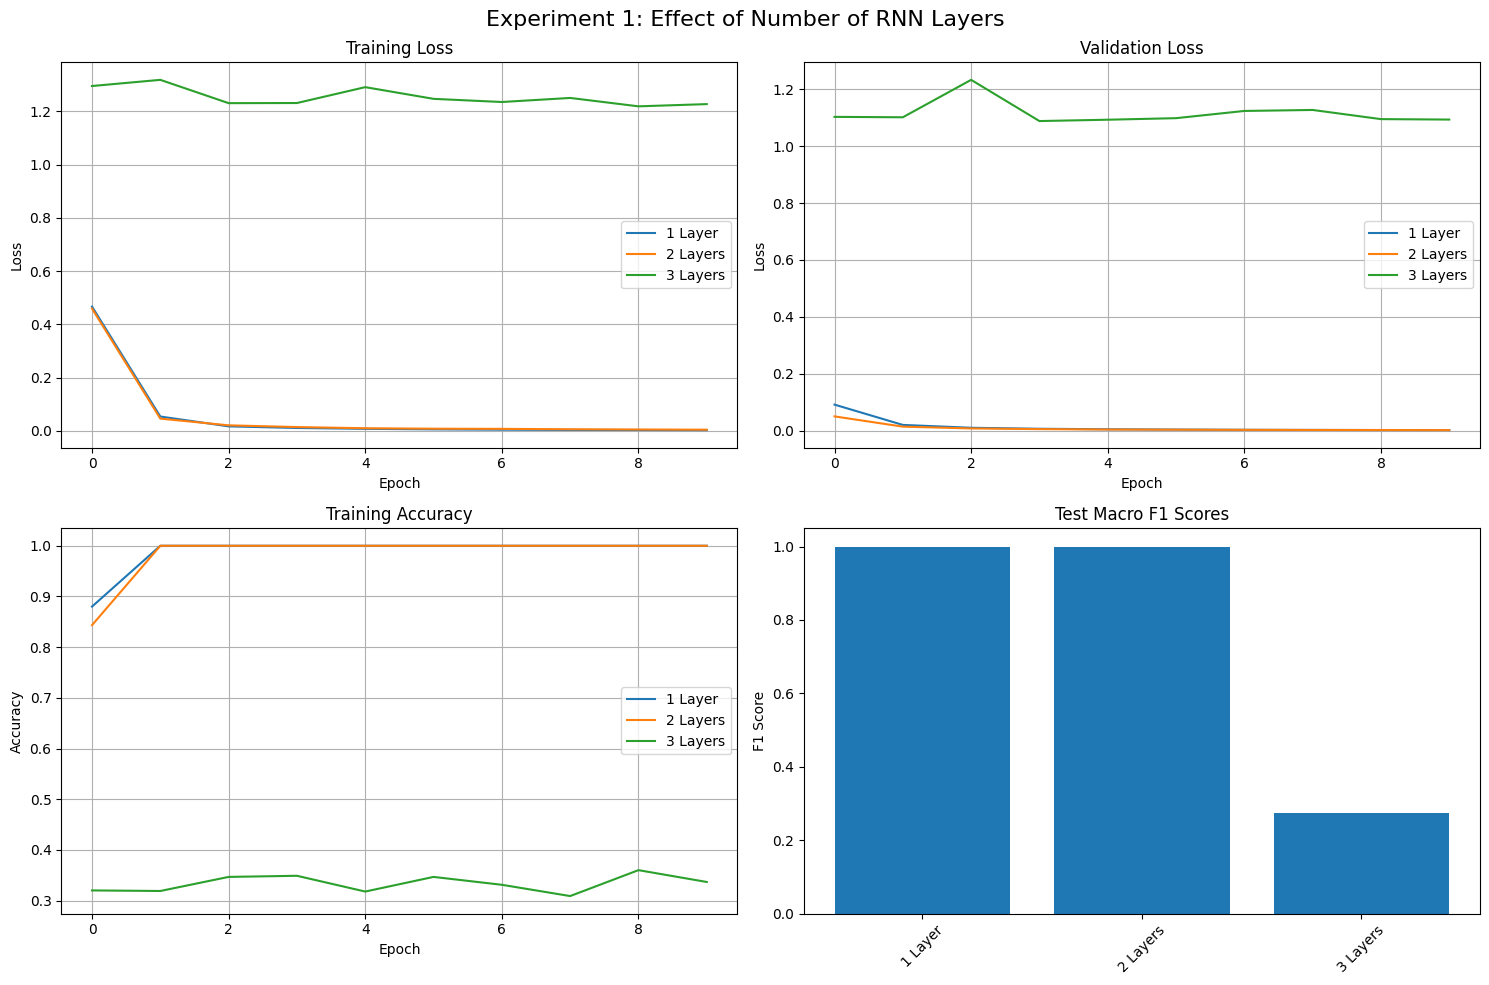

In [6]:
# Plot training curves for Experiment 1
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 1: Effect of Number of RNN Layers', fontsize=16)

# Training Loss
axes[0, 0].set_title('Training Loss')
for name, result in experiment1_results.items():
    axes[0, 0].plot(result['history'].history['loss'], label=name)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Validation Loss
axes[0, 1].set_title('Validation Loss')
for name, result in experiment1_results.items():
    axes[0, 1].plot(result['history'].history['val_loss'], label=name)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Training Accuracy
axes[1, 0].set_title('Training Accuracy')
for name, result in experiment1_results.items():
    axes[1, 0].plot(result['history'].history['accuracy'], label=name)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Macro F1 Scores
names = list(experiment1_results.keys())
f1_scores = [experiment1_results[name]['test_f1'] for name in names]
axes[1, 1].bar(names, f1_scores)
axes[1, 1].set_title('Test Macro F1 Scores')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Experiment 2: Effect of RNN Units per Layer

In [7]:
print("=" * 60)
print("EXPERIMENT 2: EFFECT OF RNN UNITS PER LAYER")
print("=" * 60)

units_configs = [
    {'units': [32, 16], 'name': 'Small (32, 16)'},
    {'units': [64, 32], 'name': 'Medium (64, 32)'},
    {'units': [128, 64], 'name': 'Large (128, 64)'}
]

experiment2_results = {}

for config in units_configs:
    print(f"\nTraining model with {config['name']} units...")
    
    # Build model
    model = build_rnn_model(
        rnn_layers=2,
        units_per_layer=config['units'],
        bidirectional=False,
        vocab_size=vocab_size,
        num_classes=num_classes,
        sequence_length=MAX_LENGTH
    )
    
    # Build the model to initialize parameters
    model.build(input_shape=(None, MAX_LENGTH))
    
    print(f"Model parameters: {model.count_params():,}")
    
    # Train and evaluate
    history, test_f1, predictions = train_and_evaluate_model(
        model, train_sequences, train_labels, val_sequences, val_labels,
        test_sequences, test_labels, epochs=10, verbose=0
    )
    
    # Store results
    experiment2_results[config['name']] = {
        'history': history,
        'test_f1': test_f1,
        'predictions': predictions,
        'model': model,
        'config': config
    }
    
    print(f"Test Macro F1 Score: {test_f1:.4f}")

# Display results summary
print("\n" + "=" * 50)
print("EXPERIMENT 2 RESULTS SUMMARY")
print("=" * 50)
for name, result in experiment2_results.items():
    print(f"{name}: Macro F1 = {result['test_f1']:.4f}")


EXPERIMENT 2: EFFECT OF RNN UNITS PER LAYER

Training model with Small (32, 16) units...
Model parameters: 12,515
Test Macro F1 Score: 1.0000

Training model with Medium (64, 32) units...
Model parameters: 22,083
Test Macro F1 Score: 1.0000

Training model with Large (128, 64) units...
Model parameters: 51,971
Test Macro F1 Score: 1.0000

EXPERIMENT 2 RESULTS SUMMARY
Small (32, 16): Macro F1 = 1.0000
Medium (64, 32): Macro F1 = 1.0000
Large (128, 64): Macro F1 = 1.0000


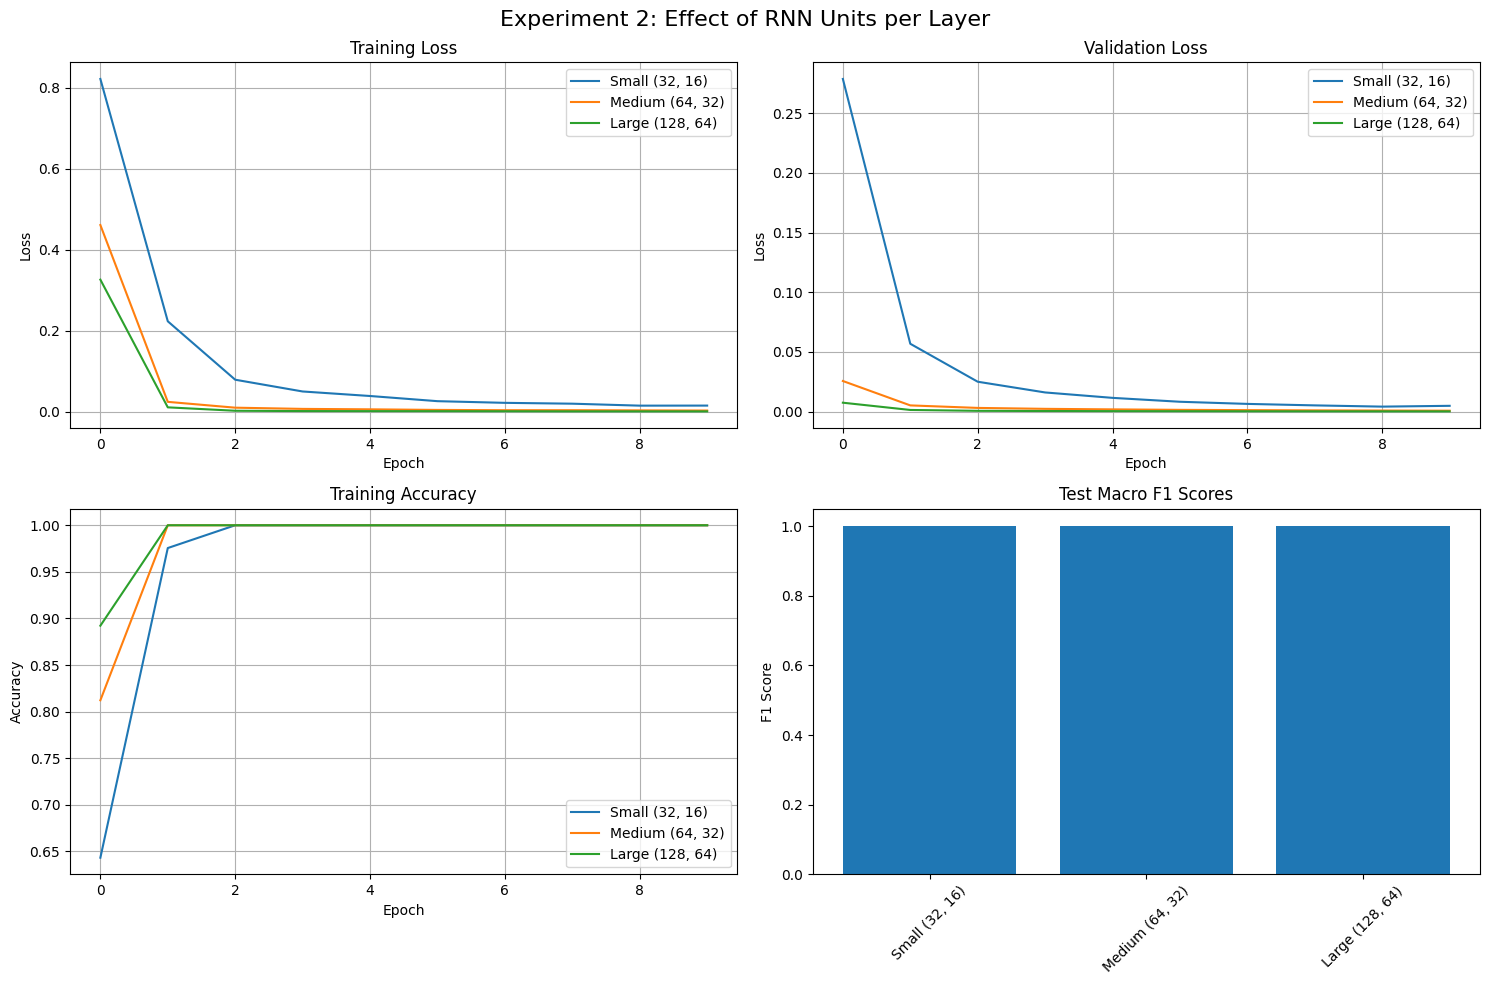

In [8]:
# Plot training curves for Experiment 2
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 2: Effect of RNN Units per Layer', fontsize=16)

# Training Loss
axes[0, 0].set_title('Training Loss')
for name, result in experiment2_results.items():
    axes[0, 0].plot(result['history'].history['loss'], label=name)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Validation Loss
axes[0, 1].set_title('Validation Loss')
for name, result in experiment2_results.items():
    axes[0, 1].plot(result['history'].history['val_loss'], label=name)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Training Accuracy
axes[1, 0].set_title('Training Accuracy')
for name, result in experiment2_results.items():
    axes[1, 0].plot(result['history'].history['accuracy'], label=name)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Macro F1 Scores
names = list(experiment2_results.keys())
f1_scores = [experiment2_results[name]['test_f1'] for name in names]
axes[1, 1].bar(names, f1_scores)
axes[1, 1].set_title('Test Macro F1 Scores')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 6. Experiment 3: Effect of RNN Direction (Bidirectional vs Unidirectional)

In [9]:
print("=" * 60)
print("EXPERIMENT 3: EFFECT OF RNN DIRECTION")
print("=" * 60)

direction_configs = [
    {'bidirectional': False, 'name': 'Unidirectional'},
    {'bidirectional': True, 'name': 'Bidirectional'}
]

experiment3_results = {}

for config in direction_configs:
    print(f"\nTraining {config['name']} RNN model...")
    
    # Build model
    model = build_rnn_model(
        rnn_layers=2,
        units_per_layer=[64, 32],
        bidirectional=config['bidirectional'],
        vocab_size=vocab_size,
        num_classes=num_classes,
        sequence_length=MAX_LENGTH
    )

    model.build(input_shape=(None, MAX_LENGTH))
    
    print(f"Model parameters: {model.count_params():,}")
    
    # Train and evaluate
    history, test_f1, predictions = train_and_evaluate_model(
        model, train_sequences, train_labels, val_sequences, val_labels,
        test_sequences, test_labels, epochs=10, verbose=0
    )
    
    # Store results
    experiment3_results[config['name']] = {
        'history': history,
        'test_f1': test_f1,
        'predictions': predictions,
        'model': model,
        'config': config
    }
    
    print(f"Test Macro F1 Score: {test_f1:.4f}")

# Display results summary
print("\n" + "=" * 50)
print("EXPERIMENT 3 RESULTS SUMMARY")
print("=" * 50)
for name, result in experiment3_results.items():
    print(f"{name}: Macro F1 = {result['test_f1']:.4f}")


EXPERIMENT 3: EFFECT OF RNN DIRECTION

Training Unidirectional RNN model...
Model parameters: 22,083
Test Macro F1 Score: 1.0000

Training Bidirectional RNN model...
Model parameters: 41,731
Test Macro F1 Score: 1.0000

EXPERIMENT 3 RESULTS SUMMARY
Unidirectional: Macro F1 = 1.0000
Bidirectional: Macro F1 = 1.0000


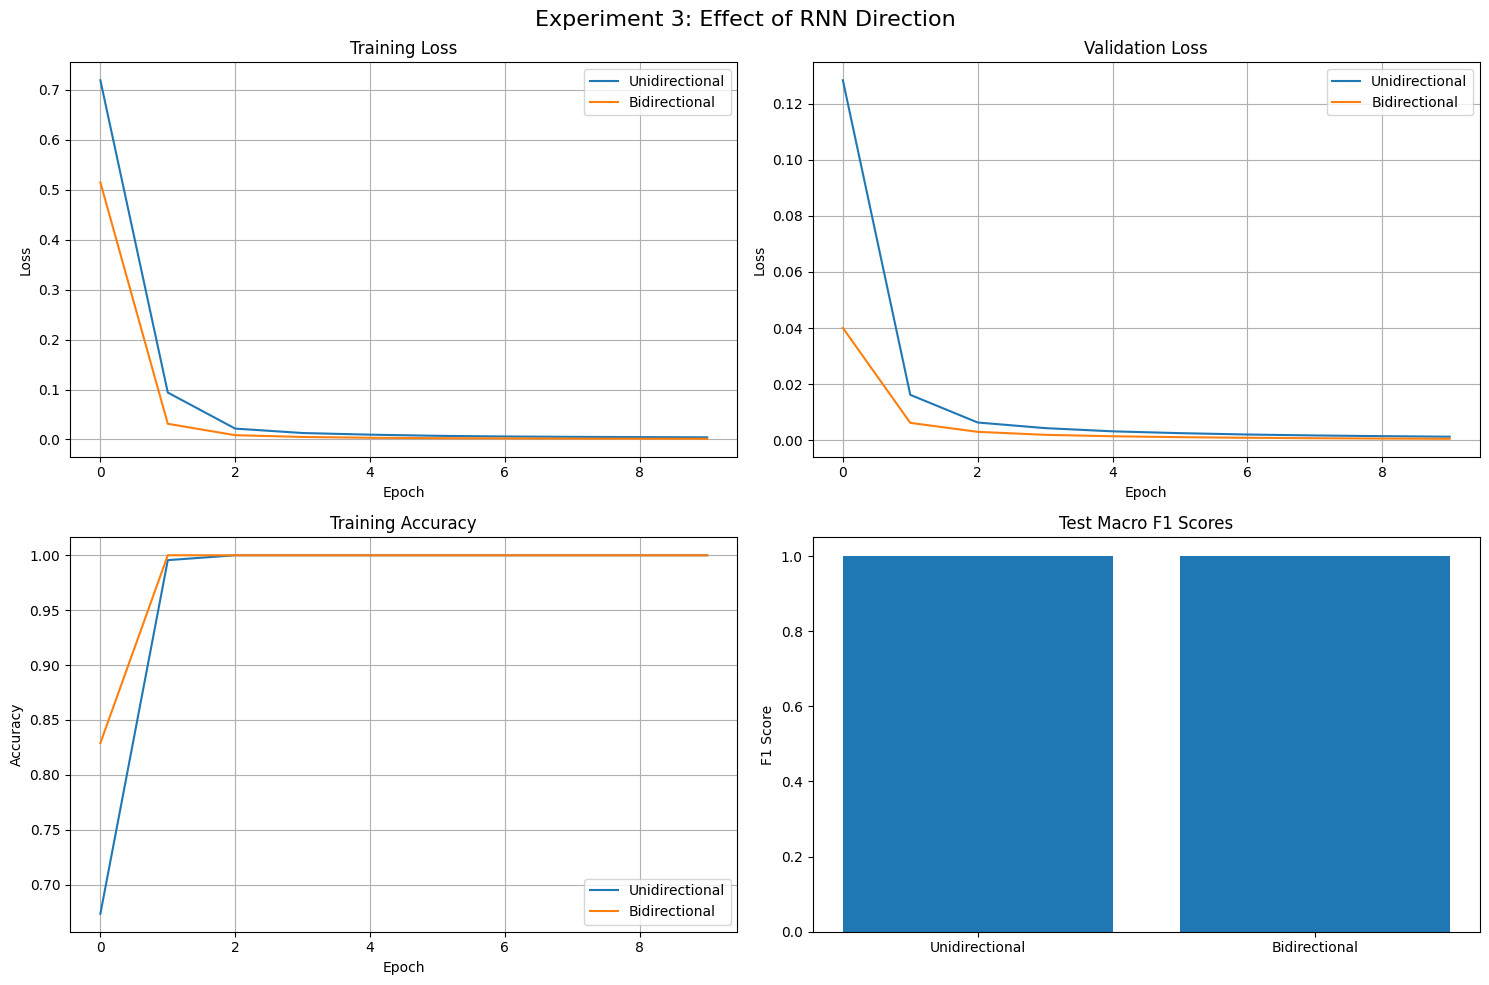

In [10]:
# Plot training curves for Experiment 3
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 3: Effect of RNN Direction', fontsize=16) 

# Training Loss
axes[0, 0].set_title('Training Loss')
for name, result in experiment3_results.items():
    axes[0, 0].plot(result['history'].history['loss'], label=name)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Validation Loss
axes[0, 1].set_title('Validation Loss')
for name, result in experiment3_results.items():
    axes[0, 1].plot(result['history'].history['val_loss'], label=name)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Training Accuracy
axes[1, 0].set_title('Training Accuracy')
for name, result in experiment3_results.items():
    axes[1, 0].plot(result['history'].history['accuracy'], label=name)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Macro F1 Scores
names = list(experiment3_results.keys())
f1_scores = [experiment3_results[name]['test_f1'] for name in names]
axes[1, 1].bar(names, f1_scores)
axes[1, 1].set_title('Test Macro F1 Scores')
axes[1, 1].set_ylabel('F1 Score')

plt.tight_layout()
plt.show()

# Import from-scratch implementation

In [11]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

try:
    from from_scratch.model import RNNModelFromScratch
    from from_scratch.layers import (
        Embedding, SimpleRNN, Bidirectional, Dropout, 
        Dense, Softmax
    )
    print("Successfully imported from-scratch modules")
except ImportError as e:
    print(f"Error importing from-scratch modules: {e}")
    print("Make sure the from_scratch directory is in the correct path")


Successfully imported from-scratch modules


In [12]:
# Find the best model across all experiments
all_results = {}
all_results.update(experiment1_results)
all_results.update(experiment2_results)
all_results.update(experiment3_results)

# Find best model
best_model_name = max(all_results.keys(), key=lambda x: all_results[x]['test_f1'])
best_result = all_results[best_model_name]
best_model = best_result['model']

print("=" * 60)
print("BEST MODEL SELECTION")
print("=" * 60)
print(f"Best Model: {best_model_name}")
print(f"Best F1 Score: {best_result['test_f1']:.4f}")

# Prepare final_results for JSON export
final_results = {
    'experiment1_results': {name: {'test_f1': result['test_f1'], 'config': result['config']} 
                           for name, result in experiment1_results.items()},
    'experiment2_results': {name: {'test_f1': result['test_f1'], 'config': result['config']} 
                           for name, result in experiment2_results.items()},
    'experiment3_results': {name: {'test_f1': result['test_f1'], 'config': result['config']} 
                           for name, result in experiment3_results.items()},
    'best_model': {
        'name': best_model_name,
        'f1_score': best_result['test_f1'],
        'config': best_result['config']
    }
}

print("\n5. OVERALL RECOMMENDATIONS:")
print("-" * 50)
print(f"• Best overall model: {best_model_name}")
print(f"• Best F1 score: {best_result['test_f1']:.4f}")
print(f"• Model complexity: {best_model.count_params():,} parameters")
print("• The from-scratch implementation demonstrates understanding of RNN internals")
print("• Basic RNNs are simpler than LSTMs but may struggle with long sequences")
print("• RNNs are faster to train but more prone to vanishing gradient problems")
print("• Model selection should balance performance and computational efficiency")

# Save results to JSON file
with open('rnn_experiment_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("Final results saved to 'rnn_experiment_results.json'")
print("\nFiles generated:")
print("- rnn_keras_best.weights.h5: Best model weights")
print("- rnn_saved_data.pkl: Test data and configuration")
print("- rnn_experiment_results.json: Experiment results summary")

BEST MODEL SELECTION
Best Model: 1 Layer
Best F1 Score: 1.0000

5. OVERALL RECOMMENDATIONS:
--------------------------------------------------
• Best overall model: 1 Layer
• Best F1 score: 1.0000
• Model complexity: 19,075 parameters
• The from-scratch implementation demonstrates understanding of RNN internals
• Basic RNNs are simpler than LSTMs but may struggle with long sequences
• RNNs are faster to train but more prone to vanishing gradient problems
• Model selection should balance performance and computational efficiency
Final results saved to 'rnn_experiment_results.json'

Files generated:
- rnn_keras_best.weights.h5: Best model weights
- rnn_saved_data.pkl: Test data and configuration
- rnn_experiment_results.json: Experiment results summary


# Save the best model weights

In [13]:
weights_path = os.path.join('..', 'rnn_keras_best.weights.h5')
best_model.save_weights(weights_path)
print(f"\nBest model weights saved to {weights_path}")

# Save model configuration for from-scratch implementation
if 'config' in best_result:
    best_config = best_result['config'].copy()
else:
    # Default config if not found
    best_config = {
        'rnn_layers': 2,
        'units_per_layer': [64, 32],
        'bidirectional': False,
        'embedding_dim': 128
    }


Best model weights saved to ..\rnn_keras_best.weights.h5


# Save data for from-scratch testing

In [14]:
# Save data for from-scratch testing
data_to_save = {
    'test_sequences': test_sequences,
    'test_labels': test_labels,
    'best_config': best_result['config'],
    'vocab_size': vocab_size,
}

# Save to parent directory (outside notebook folder)
output_path = os.path.join('..', 'rnn_saved_data.pkl')
with open(output_path, 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"Data successfully saved to {output_path}")

Data successfully saved to ..\rnn_saved_data.pkl
